In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8)

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  9999
number of successfully processed smiles:  9999


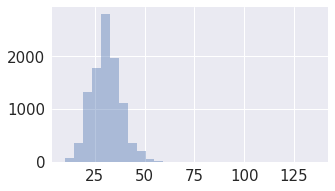

In [3]:
task_name = 'Malaria Bioactivity'
tasks = ['Loge EC50']

raw_filename = "../data/malaria-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename, names = ["Loge EC50", "smiles"])
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [4]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 800

p_dropout= 0.03
fingerprint_dim = 200

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,Loge EC50,smiles,cano_smiles


In [6]:
test_df = remained_df.sample(frac=0.2,random_state=random_seed)
train_df = remained_df.drop(test_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
# print(len(test_df),sorted(test_df.cano_smiles.values))

In [7]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [8]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        optimizer.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()


In [9]:
best_param ={}
best_param["train_epoch"] = 0
best_param["test_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    test_MAE, test_MSE = eval(model, test_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':test_MAE, 'test_MAE':test_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':test_MAE, 'test_MSE':test_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE
        if test_MSE < 1.1:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["test_epoch"] >18):        
        break
    print(epoch, train_MSE, test_MSE)
    
    train(model, train_df, optimizer, loss_function)


0 1.5478796 1.628472
1 1.448478 1.5302224
2 1.4498698 1.5333989
3 1.425018 1.505234
4 1.441523 1.5231948
5 1.4017888 1.4746803
6 1.3749068 1.4464937
7 1.3531059 1.4220781
8 1.3480316 1.4143926
9 1.3431658 1.3971175
10 1.2978153 1.3485527
11 1.2780799 1.3257537
12 1.2728355 1.3112742
13 1.3038107 1.335188
14 1.2483072 1.2825298
15 1.2388601 1.2719156
16 1.2517695 1.2779336
17 1.2320278 1.258369
18 1.2472036 1.2736138
19 1.2221298 1.2528942
20 1.2216604 1.2494508
21 1.2252085 1.2557986
22 1.2185632 1.2483377
23 1.2103592 1.2352843
24 1.2274623 1.2619636
25 1.2248856 1.2448567
26 1.2058675 1.2268171
27 1.1973008 1.2225409
28 1.2388365 1.2538594
29 1.1966963 1.2268447
30 1.1990334 1.2282244
31 1.2003697 1.2185816
32 1.1839876 1.2106801
33 1.1827517 1.2043097
34 1.1821854 1.2080361
35 1.192607 1.2253516
36 1.1787097 1.2061633
37 1.1723497 1.1951882
38 1.1703535 1.1923693
39 1.1852618 1.2026875
40 1.1674594 1.1937082
41 1.1659837 1.1897207
42 1.1686869 1.1905769
43 1.1777316 1.2105943
44 1.1

In [10]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

best epoch: 240 
 test MSE: 1.0443797
